Associated Blog Post: [How to Export a PyTorch Model to ONNX](https://mlbasics.com/export-pytorch-model-onnx/)

In [1]:
import json
import onnx
import torch
import numpy as np
from PIL import Image
import onnxruntime as rt
import matplotlib.pyplot as plt
from torchvision import transforms
from rich.jupyter import print as rprint

# custom import
from mobilevit import MobileViT

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# variables

export_device = "cpu"
pytorch_model_weight = "mobilevit_s_birds400.pth"

In [3]:
# define model - MobileViT 'S' architecture
dims = [144, 192, 240]
channels = [16, 32, 64, 64, 96, 96, 128, 128, 160, 160, 640]
model = MobileViT((256, 256), dims, channels, num_classes=400)

# load saved model weights
model.load_state_dict(torch.load(pytorch_model_weight, map_location=export_device))

# move model to correct environment/device
model.to(export_device)

# put model to evaluation mode
model.eval()

MobileViT(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (mv2): ModuleList(
    (0): MV2Block(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): SiLU()
        (6): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MV2Block(
      (conv): Sequential(
        (0): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [4]:
# create dummy input
dummy_input = torch.rand(1, 3, 256, 256, requires_grad=True).to(export_device)

In [5]:
# test eager model inference
torch_output = model(dummy_input)

rprint(f'[bold dodger_blue3]Torch Eager Model Output Shape: {torch_output.shape}')

Torch Eager Model Output Shape: torch.Size([1, 400])

In [6]:
# onnx model input and output names
input_names = ['input']
output_names = ['output']

In [7]:
# trace ONNX model
torch.onnx.export(
        model,  # MobileVit Eager Model
        dummy_input,  # dummy tensor input
        'mobilevit_s_birds400.onnx',  # ONNX weights save path
        export_params=True,  # store trained parameters in ONNX model
        opset_version=16,  # ONNX version for exported model
        do_constant_folding=True,  # apply constant-folding optimization
        input_names=input_names,  # ONNX model input names
        output_names=output_names,  # ONNX model output names
)

In [8]:
# check ONNX export
onnx_model = onnx.load('mobilevit_s_birds400.onnx')
onnx.checker.check_model(onnx_model)

In [9]:
# validate whether eager model output and onnx model output are same/similar

# onnxruntime inference session
ort_session = rt.InferenceSession('mobilevit_s_birds400.onnx')

# compute ONNX output
ort_input = {ort_session.get_inputs()[0].name: dummy_input.detach().cpu().numpy()}
ort_output = ort_session.run(None, ort_input)

# compare onnxruntime and eager model outputs
np.testing.assert_allclose(torch_output.detach().cpu().numpy(), ort_output[0], rtol=1e-03, atol=1e-06)

rprint('[bold dark_sea_green4]Both onnxruntime and eager model outputs are same/similar!')

Both onnxruntime and eager model outputs are same/similar!

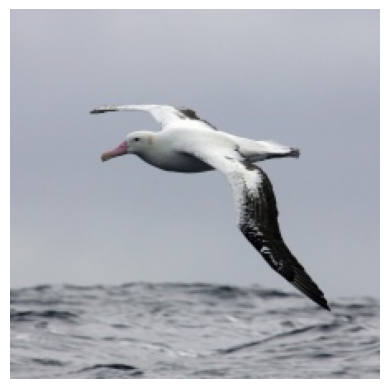

Prediction: ALBATROSS

In [10]:
# ONNX Runtime inference on an actual image

# define image transforms
valid_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# read image
test_imgpath = 'albatross.jpg'
test_img = Image.open(test_imgpath)

# apply transforms
test_img = valid_transforms(test_img)

# create batch
test_img.unsqueeze_(0)

# compute ONNX output
ort_input = {ort_session.get_inputs()[0].name: test_img.detach().cpu().numpy()}
ort_output = ort_session.run(None, ort_input)[0]

# read idx2class mapping JSON - stored during the training session
with open('mobilevit_birds400_idx2class.json') as f:
    idx2class = json.load(f)

# convert to human-understandable output
ort_output = np.argmax(ort_output).tolist()
ort_output = idx2class.get(str(ort_output))

# print results
plt.imshow(np.array(Image.open(test_imgpath), dtype=np.uint8))
plt.axis('off')
plt.show()
rprint(f'[b][slate_blue1]Prediction:[/b] {ort_output}')